In [3]:
import openmc
import openmc.lib
import numpy as np
import os
from uncertainties import ufloat
from uncertainties.umath import *
import matplotlib.pyplot as plt

os.environ['OPENMC_CROSS_SECTIONS'] = "/home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/cross_sections.xml"

.

.

.

.

# QUESTION 2

The reference k-inf for our system (computed in Q1) is about 1.31.

The first operation to increase the eigenvalue of our system is to remove the cladding which servers just a safety and structural role and brings no neutronic advantages.

## REMOVE CLADDING

In [18]:
k_ref = ufloat(1.31095, 0.00033)

In [19]:
def ref_no_clad(nps):
    fuel_enrichment = 3.0
    pitch = 1.25 # cm
    z_max = 1.0

    fuel_OR = 0.39218 # cm

    fuel_density = 10.31341 # g/cm3

    fuel_temperature = 900 #K
    mod_temperature = 600 #K


    ############### DEFINE MATERIALS

    fuel = openmc.Material(name='fuel')
    fuel.add_element('U', 1, enrichment=fuel_enrichment)
    fuel.add_element('O', 2)
    fuel.set_density('g/cc', fuel_density)
    fuel.temperature = fuel_temperature

    mod = openmc.model.borated_water(boron_ppm=0, temperature=mod_temperature, pressure=15, temp_unit='K', 
                                 press_unit='MPa')

    materials = openmc.Materials([fuel, mod])
    materials.export_to_xml()



    ############### DEFINE GEOMETRY

    cyl_fo = openmc.ZCylinder(r=fuel_OR)
    box = openmc.model.rectangular_prism(pitch, pitch, boundary_type='reflective')
    z0 = openmc.ZPlane(z0=-z_max, boundary_type='reflective')
    z1 = openmc.ZPlane(z0=z_max, boundary_type='reflective')

    fuel_cell = openmc.Cell(name='fuel', fill=fuel)
    fuel_cell.region = -cyl_fo & +z0 & -z1
    mod_cell = openmc.Cell(name='moderator', fill=mod)
    mod_cell.region = +cyl_fo & box & +z0 & -z1

    pin_univ = openmc.Universe(cells=(fuel_cell, mod_cell))
    geometry = openmc.Geometry(pin_univ)
    geometry.export_to_xml()


    ############### DEFINE SETTINGS
    settings = openmc.Settings()
    settings.inactive = 50
    settings.batches = 200
    settings.particles = nps 
    settings.temperature={'method': 'interpolation','range':(300,1200)}

    lower_left = np.array([-pitch/2, -pitch/2, -z_max/2])
    upper_right = np.array([pitch/2, pitch/2, z_max/2])

    box = openmc.stats.Box(lower_left, upper_right, only_fissionable=True)
    src = openmc.Source(space=box)
    settings.source = src

    settings.export_to_xml()


    ############### RUN
    openmc.lib.init()
    openmc.lib.run()
    k = openmc.lib.keff()
    k = ufloat(k[0],k[1])
    openmc.lib.finalize()
    
    return k

In [20]:
k_ref_noclad = ref_no_clad(50000)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      134/1    1.36440    1.35446 +/- 0.00082
      135/1    1.36684    1.35461 +/- 0.00082
      136/1    1.34651    1.35451 +/- 0.00082
      137/1    1.34865    1.35445 +/- 0.00081
      138/1    1.35057    1.35440 +/- 0.00080
      139/1    1.34695    1.35432 +/- 0.00080
      140/1    1.35353    1.35431 +/- 0.00079
      141/1    1.36601    1.35444 +/- 0.00079
      142/1    1.34387    1.35432 +/- 0.00079
      143/1    1.35479    1.35433 +/- 0.00078
      144/1    1.35449    1.35433 +/- 0.00077
      145/1    1.34139    1.35419 +/- 0.00078
      146/1    1.36388    1.35429 +/- 0.00078
      147/1    1.35341    1.35428 +/- 0.00077
      148/1    1.36122    1.35436 +/- 0.00076
      149/1    1.35880    1.35440 +/- 0.00076
      150/1    1.36538    1.35451 +/- 0.00076
      151/1    1.36047    1.35457 +/- 0.00075
      152/1    1.36416    1.35466 +/- 0.00075
      153/1    1.35159    1.35463 +/- 0.00074
      154/1    1.35955    1.35468 +/- 0.00074
      155/1    1.35543    1.35469 

In [21]:
# COMPUTE REACTIVITY CHANGE

rea_noclad = (1/k_ref - 1/k_ref_noclad)*1e5
print("Removing the cladding yields a reactivity change of {:.0f} +/- {:.0f} pcm.".format(rea_noclad.nominal_value, rea_noclad.std_dev))

Removing the cladding yields a reactivity change of 2439 +/- 27 pcm.


.

## BERYLLIUM

The next step is to use a better moderator and optimize the pitch size. My first try is Beryllium.

In [6]:
def beryllium(nps, pitch):
    fuel_enrichment = 3.0
    z_max = 1.0

    fuel_OR = 0.39218 # cm

    fuel_density = 10.31341 # g/cm3

    fuel_temperature = 900 #K
    mod_temperature = 600 #K


    ############### DEFINE MATERIALS

    fuel = openmc.Material(name='fuel')
    fuel.add_element('U', 1, enrichment=fuel_enrichment)
    fuel.add_element('O', 2)
    fuel.set_density('g/cc', fuel_density)
    fuel.temperature = fuel_temperature

    mod = openmc.Material(name='mod')
    mod.add_element('Be', 100.0, 'wo')
    mod.set_density('g/cc', 1.85)
    mod.temperature = mod_temperature
    mod.add_s_alpha_beta('c_Be')

    materials = openmc.Materials([fuel, mod])
    materials.export_to_xml()



    ############### DEFINE GEOMETRY

    cyl_fo = openmc.ZCylinder(r=fuel_OR)
    box = openmc.model.rectangular_prism(pitch, pitch, boundary_type='reflective')
    z0 = openmc.ZPlane(z0=-z_max, boundary_type='reflective')
    z1 = openmc.ZPlane(z0=z_max, boundary_type='reflective')

    fuel_cell = openmc.Cell(name='fuel', fill=fuel)
    fuel_cell.region = -cyl_fo & +z0 & -z1
    mod_cell = openmc.Cell(name='moderator', fill=mod)
    mod_cell.region = +cyl_fo & box & +z0 & -z1

    pin_univ = openmc.Universe(cells=(fuel_cell, mod_cell))
    geometry = openmc.Geometry(pin_univ)
    geometry.export_to_xml()


    ############### DEFINE SETTINGS
    settings = openmc.Settings()
    settings.inactive = 50
    settings.batches = 200
    settings.particles = nps 
    settings.temperature={'method': 'interpolation','range':(300,1200)}

    lower_left = np.array([-pitch/2, -pitch/2, -z_max/2])
    upper_right = np.array([pitch/2, pitch/2, z_max/2])

    box = openmc.stats.Box(lower_left, upper_right, only_fissionable=True)
    src = openmc.Source(space=box)
    settings.source = src

    settings.export_to_xml()


    ############### RUN
    openmc.lib.init()
    openmc.lib.run()
    k = openmc.lib.keff()
    k = ufloat(k[0],k[1])
    openmc.lib.finalize()
    
    return k

In [7]:
pp = np.linspace(3, 6, 20)
kk_beryllium = []


for p in pp:
    kk_beryllium.append(beryllium(nps=10000, pitch=p))

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      141/1    1.51341    1.50834 +/- 0.00184
      142/1    1.48053    1.50803 +/- 0.00184
      143/1    1.48861    1.50782 +/- 0.00184
      144/1    1.53084    1.50807 +/- 0.00183
      145/1    1.49655    1.50795 +/- 0.00182
      146/1    1.54319    1.50831 +/- 0.00184
      147/1    1.50962    1.50833 +/- 0.00182
      148/1    1.53059    1.50856 +/- 0.00181
      149/1    1.51555    1.50863 +/- 0.00180
      150/1    1.50921    1.50863 +/- 0.00178
      151/1    1.51418    1.50869 +/- 0.00176
      152/1    1.53545    1.50895 +/- 0.00176
      153/1    1.51698    1.50903 +/- 0.00175
      154/1    1.50345    1.50897 +/- 0.00173
      155/1    1.51163    1.50900 +/- 0.00171
      156/1    1.49513    1.50887 +/- 0.00170
      157/1    1.49731    1.50876 +/- 0.00169
      158/1    1.49070    1.50859 +/- 0.00168
      159/1    1.49318    1.50845 +/- 0.00167
      160/1    1.49173    1.50830 +/- 0.00167
      161/1    1.52003    1.50840 +/- 0.00165
      162/1    1.47727    1.50813 

       49/1    1.52262
       50/1    1.51330
       51/1    1.53145
       52/1    1.53209    1.53177 +/- 0.00032
       53/1    1.52094    1.52816 +/- 0.00362
       54/1    1.53083    1.52883 +/- 0.00264
       55/1    1.51116    1.52529 +/- 0.00408
       56/1    1.56321    1.53161 +/- 0.00715
       57/1    1.51481    1.52921 +/- 0.00650
       58/1    1.49880    1.52541 +/- 0.00679
       59/1    1.49036    1.52152 +/- 0.00714
       60/1    1.53660    1.52303 +/- 0.00657
       61/1    1.52439    1.52315 +/- 0.00594
       62/1    1.50711    1.52181 +/- 0.00559
       63/1    1.51769    1.52150 +/- 0.00515
       64/1    1.53756    1.52264 +/- 0.00490
       65/1    1.50833    1.52169 +/- 0.00466
       66/1    1.53287    1.52239 +/- 0.00442
       67/1    1.52274    1.52241 +/- 0.00415
       68/1    1.47496    1.51977 +/- 0.00472
       69/1    1.54408    1.52105 +/- 0.00464
       70/1    1.57824    1.52391 +/- 0.00525
       71/1    1.51943    1.52370 +/- 0.00500
       72/1

 Reading U235 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U235.h5
 Reading U238 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U238.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading Be9 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/Be9.h5
 Reading c_Be from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_Be.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O18
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     

      182/1    1.53005    1.54420 +/- 0.00150
      183/1    1.53660    1.54415 +/- 0.00149
      184/1    1.53233    1.54406 +/- 0.00149
      185/1    1.56524    1.54422 +/- 0.00148
      186/1    1.53671    1.54416 +/- 0.00147
      187/1    1.54287    1.54415 +/- 0.00146
      188/1    1.56931    1.54433 +/- 0.00146
      189/1    1.54154    1.54431 +/- 0.00145
      190/1    1.54156    1.54429 +/- 0.00144
      191/1    1.52231    1.54414 +/- 0.00144
      192/1    1.51428    1.54393 +/- 0.00145
      193/1    1.53510    1.54387 +/- 0.00144
      194/1    1.54718    1.54389 +/- 0.00143
      195/1    1.53843    1.54385 +/- 0.00142
      196/1    1.55208    1.54391 +/- 0.00141
      197/1    1.57295    1.54410 +/- 0.00141
      198/1    1.54125    1.54409 +/- 0.00140
      199/1    1.52508    1.54396 +/- 0.00140
      200/1    1.54113    1.54394 +/- 0.00139
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Tot

       94/1    1.57801    1.55967 +/- 0.00277
       95/1    1.53816    1.55919 +/- 0.00275
       96/1    1.56708    1.55936 +/- 0.00269
       97/1    1.53386    1.55882 +/- 0.00269
       98/1    1.55691    1.55878 +/- 0.00264
       99/1    1.55206    1.55864 +/- 0.00258
      100/1    1.56258    1.55872 +/- 0.00253
      101/1    1.54290    1.55841 +/- 0.00250
      102/1    1.57566    1.55874 +/- 0.00248
      103/1    1.52103    1.55803 +/- 0.00253
      104/1    1.56688    1.55819 +/- 0.00249
      105/1    1.57665    1.55853 +/- 0.00247
      106/1    1.56564    1.55866 +/- 0.00243
      107/1    1.58458    1.55911 +/- 0.00243
      108/1    1.56301    1.55918 +/- 0.00238
      109/1    1.55717    1.55914 +/- 0.00234
      110/1    1.54712    1.55894 +/- 0.00231
      111/1    1.55528    1.55888 +/- 0.00228
      112/1    1.56348    1.55896 +/- 0.00224
      113/1    1.54512    1.55874 +/- 0.00222
      114/1    1.54414    1.55851 +/- 0.00219
      115/1    1.54849    1.55836 

 Reading U238 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U238.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading Be9 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/Be9.h5
 Reading c_Be from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_Be.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O18
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   =======

      183/1    1.55465    1.56483 +/- 0.00166
      184/1    1.55941    1.56479 +/- 0.00165
      185/1    1.57863    1.56489 +/- 0.00164
      186/1    1.58891    1.56507 +/- 0.00164
      187/1    1.55358    1.56498 +/- 0.00163
      188/1    1.57961    1.56509 +/- 0.00162
      189/1    1.56617    1.56510 +/- 0.00161
      190/1    1.58139    1.56521 +/- 0.00160
      191/1    1.56037    1.56518 +/- 0.00159
      192/1    1.56338    1.56517 +/- 0.00158
      193/1    1.56602    1.56517 +/- 0.00157
      194/1    1.60415    1.56544 +/- 0.00158
      195/1    1.56082    1.56541 +/- 0.00157
      196/1    1.55418    1.56533 +/- 0.00156
      197/1    1.58212    1.56545 +/- 0.00155
      198/1    1.56360    1.56544 +/- 0.00154
      199/1    1.57035    1.56547 +/- 0.00153
      200/1    1.57459    1.56553 +/- 0.00152
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 1.9794e+00 se

       93/1    1.56770    1.57371 +/- 0.00283
       94/1    1.56750    1.57357 +/- 0.00277
       95/1    1.56426    1.57336 +/- 0.00271
       96/1    1.58117    1.57353 +/- 0.00266
       97/1    1.57626    1.57359 +/- 0.00260
       98/1    1.56903    1.57349 +/- 0.00255
       99/1    1.55430    1.57310 +/- 0.00253
      100/1    1.57129    1.57306 +/- 0.00247
      101/1    1.59952    1.57358 +/- 0.00248
      102/1    1.57760    1.57366 +/- 0.00243
      103/1    1.57947    1.57377 +/- 0.00239
      104/1    1.59032    1.57408 +/- 0.00236
      105/1    1.58999    1.57437 +/- 0.00234
      106/1    1.55947    1.57410 +/- 0.00231
      107/1    1.59935    1.57454 +/- 0.00231
      108/1    1.57697    1.57458 +/- 0.00227
      109/1    1.55547    1.57426 +/- 0.00226
      110/1    1.58385    1.57442 +/- 0.00223
      111/1    1.57422    1.57442 +/- 0.00219
      112/1    1.56942    1.57434 +/- 0.00216
      113/1    1.60825    1.57488 +/- 0.00219
      114/1    1.57450    1.57487 

 Reading U238 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U238.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading Be9 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/Be9.h5
 Reading c_Be from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_Be.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O18
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   =======

      183/1    1.54989    1.58121 +/- 0.00149
      184/1    1.60295    1.58137 +/- 0.00149
      185/1    1.60005    1.58151 +/- 0.00148
      186/1    1.56927    1.58142 +/- 0.00148
      187/1    1.56876    1.58133 +/- 0.00147
      188/1    1.57441    1.58128 +/- 0.00146
      189/1    1.57162    1.58121 +/- 0.00145
      190/1    1.58848    1.58126 +/- 0.00144
      191/1    1.57722    1.58123 +/- 0.00143
      192/1    1.59773    1.58135 +/- 0.00142
      193/1    1.57387    1.58130 +/- 0.00142
      194/1    1.57141    1.58123 +/- 0.00141
      195/1    1.56785    1.58114 +/- 0.00140
      196/1    1.58544    1.58117 +/- 0.00139
      197/1    1.60564    1.58133 +/- 0.00139
      198/1    1.56815    1.58124 +/- 0.00139
      199/1    1.57439    1.58120 +/- 0.00138
      200/1    1.57409    1.58115 +/- 0.00137
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 1.8183e+00 se

       93/1    1.57875    1.58506 +/- 0.00304
       94/1    1.62379    1.58594 +/- 0.00310
       95/1    1.61789    1.58665 +/- 0.00311
       96/1    1.55238    1.58591 +/- 0.00313
       97/1    1.57601    1.58569 +/- 0.00307
       98/1    1.60548    1.58611 +/- 0.00304
       99/1    1.59601    1.58631 +/- 0.00298
      100/1    1.59149    1.58641 +/- 0.00292
      101/1    1.60336    1.58675 +/- 0.00288
      102/1    1.60476    1.58709 +/- 0.00285
      103/1    1.58122    1.58698 +/- 0.00280
      104/1    1.62029    1.58760 +/- 0.00281
      105/1    1.59641    1.58776 +/- 0.00277
      106/1    1.58775    1.58776 +/- 0.00272
      107/1    1.58175    1.58765 +/- 0.00267
      108/1    1.58902    1.58768 +/- 0.00262
      109/1    1.59363    1.58778 +/- 0.00258
      110/1    1.59110    1.58783 +/- 0.00254
      111/1    1.59496    1.58795 +/- 0.00250
      112/1    1.58096    1.58784 +/- 0.00246
      113/1    1.61586    1.58828 +/- 0.00246
      114/1    1.61230    1.58866 

 Reading U238 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U238.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading Be9 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/Be9.h5
 Reading c_Be from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_Be.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O18
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   =======

      184/1    1.58313    1.58370 +/- 0.00141
      185/1    1.60520    1.58386 +/- 0.00141
      186/1    1.56359    1.58371 +/- 0.00141
      187/1    1.58701    1.58373 +/- 0.00140
      188/1    1.59441    1.58381 +/- 0.00139
      189/1    1.60959    1.58400 +/- 0.00139
      190/1    1.58437    1.58400 +/- 0.00138
      191/1    1.58191    1.58398 +/- 0.00137
      192/1    1.58490    1.58399 +/- 0.00137
      193/1    1.58386    1.58399 +/- 0.00136
      194/1    1.62136    1.58425 +/- 0.00137
      195/1    1.58033    1.58422 +/- 0.00136
      196/1    1.56177    1.58407 +/- 0.00136
      197/1    1.60368    1.58420 +/- 0.00136
      198/1    1.59345    1.58426 +/- 0.00135
      199/1    1.57462    1.58420 +/- 0.00134
      200/1    1.57731    1.58415 +/- 0.00133
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 1.9891e+00 seconds
   Reading cross sections          = 1.9

       95/1    1.61398    1.58693 +/- 0.00269
       96/1    1.60796    1.58738 +/- 0.00267
       97/1    1.59796    1.58761 +/- 0.00262
       98/1    1.56995    1.58724 +/- 0.00260
       99/1    1.57067    1.58690 +/- 0.00256
      100/1    1.59345    1.58703 +/- 0.00252
      101/1    1.54878    1.58628 +/- 0.00258
      102/1    1.58057    1.58617 +/- 0.00253
      103/1    1.58002    1.58606 +/- 0.00248
      104/1    1.58273    1.58600 +/- 0.00244
      105/1    1.61696    1.58656 +/- 0.00246
      106/1    1.60632    1.58691 +/- 0.00244
      107/1    1.59026    1.58697 +/- 0.00240
      108/1    1.58491    1.58693 +/- 0.00236
      109/1    1.60501    1.58724 +/- 0.00234
      110/1    1.59904    1.58744 +/- 0.00231
      111/1    1.58257    1.58736 +/- 0.00227
      112/1    1.59039    1.58741 +/- 0.00223
      113/1    1.56748    1.58709 +/- 0.00222
      114/1    1.57789    1.58695 +/- 0.00219
      115/1    1.57141    1.58671 +/- 0.00217
      116/1    1.55999    1.58630 

 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading Be9 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/Be9.h5
 Reading c_Be from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_Be.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O18
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.57983
        2/1    1.57774
        3/1  

       90/1    1.58292    1.58180 +/- 0.00246
       91/1    1.57369    1.58160 +/- 0.00241
       92/1    1.57393    1.58142 +/- 0.00236
       93/1    1.60113    1.58188 +/- 0.00235
       94/1    1.60357    1.58237 +/- 0.00235
       95/1    1.60965    1.58298 +/- 0.00237
       96/1    1.57139    1.58272 +/- 0.00233
       97/1    1.57859    1.58264 +/- 0.00229
       98/1    1.57357    1.58245 +/- 0.00225
       99/1    1.57632    1.58232 +/- 0.00220
      100/1    1.61327    1.58294 +/- 0.00225
      101/1    1.58399    1.58296 +/- 0.00220
      102/1    1.61245    1.58353 +/- 0.00223
      103/1    1.56666    1.58321 +/- 0.00221
      104/1    1.57460    1.58305 +/- 0.00218
      105/1    1.59095    1.58320 +/- 0.00214
      106/1    1.59291    1.58337 +/- 0.00211
      107/1    1.57401    1.58320 +/- 0.00208
      108/1    1.55324    1.58269 +/- 0.00211
      109/1    1.54314    1.58202 +/- 0.00218
      110/1    1.57434    1.58189 +/- 0.00214
      111/1    1.57630    1.58180 

 Reading U238 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U238.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading Be9 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/Be9.h5
 Reading c_Be from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_Be.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O18
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   =======

      184/1    1.55091    1.57743 +/- 0.00173
      185/1    1.57143    1.57739 +/- 0.00172
      186/1    1.57920    1.57740 +/- 0.00171
      187/1    1.57997    1.57742 +/- 0.00169
      188/1    1.59639    1.57756 +/- 0.00169
      189/1    1.56396    1.57746 +/- 0.00168
      190/1    1.56217    1.57735 +/- 0.00167
      191/1    1.58253    1.57739 +/- 0.00166
      192/1    1.57818    1.57739 +/- 0.00165
      193/1    1.57940    1.57741 +/- 0.00163
      194/1    1.58632    1.57747 +/- 0.00162
      195/1    1.61183    1.57771 +/- 0.00163
      196/1    1.56489    1.57762 +/- 0.00162
      197/1    1.59363    1.57773 +/- 0.00161
      198/1    1.64778    1.57820 +/- 0.00167
      199/1    1.59027    1.57828 +/- 0.00166
      200/1    1.55428    1.57812 +/- 0.00166
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 1.5231e+00 seconds
   Reading cross sections          = 1.5

       94/1    1.61198    1.57374 +/- 0.00238
       95/1    1.58374    1.57396 +/- 0.00234
       96/1    1.54995    1.57344 +/- 0.00235
       97/1    1.58360    1.57365 +/- 0.00231
       98/1    1.56901    1.57356 +/- 0.00226
       99/1    1.56109    1.57330 +/- 0.00223
      100/1    1.58658    1.57357 +/- 0.00220
      101/1    1.60058    1.57410 +/- 0.00222
      102/1    1.54549    1.57355 +/- 0.00225
      103/1    1.56992    1.57348 +/- 0.00220
      104/1    1.57461    1.57350 +/- 0.00216
      105/1    1.55853    1.57323 +/- 0.00214
      106/1    1.55692    1.57294 +/- 0.00212
      107/1    1.56662    1.57283 +/- 0.00209
      108/1    1.56261    1.57265 +/- 0.00206
      109/1    1.56777    1.57257 +/- 0.00202
      110/1    1.57183    1.57256 +/- 0.00199
      111/1    1.56288    1.57240 +/- 0.00196
      112/1    1.57274    1.57240 +/- 0.00193
      113/1    1.55952    1.57220 +/- 0.00191
      114/1    1.58211    1.57235 +/- 0.00189
      115/1    1.56432    1.57223 

 Reading U238 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U238.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading Be9 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/Be9.h5
 Reading c_Be from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_Be.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O18
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   =======

      183/1    1.56687    1.57134 +/- 0.00161
      184/1    1.57120    1.57134 +/- 0.00159
      185/1    1.55250    1.57120 +/- 0.00159
      186/1    1.56356    1.57114 +/- 0.00158
      187/1    1.57849    1.57119 +/- 0.00157
      188/1    1.52576    1.57087 +/- 0.00159
      189/1    1.58215    1.57095 +/- 0.00158
      190/1    1.58604    1.57105 +/- 0.00157
      191/1    1.60158    1.57127 +/- 0.00158
      192/1    1.56541    1.57123 +/- 0.00157
      193/1    1.57707    1.57127 +/- 0.00155
      194/1    1.54471    1.57109 +/- 0.00156
      195/1    1.57541    1.57112 +/- 0.00154
      196/1    1.56658    1.57108 +/- 0.00153
      197/1    1.58682    1.57119 +/- 0.00153
      198/1    1.58378    1.57128 +/- 0.00152
      199/1    1.57803    1.57132 +/- 0.00151
      200/1    1.58869    1.57144 +/- 0.00150
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.1696e+00 se

       94/1    1.56311    1.56040 +/- 0.00191
       95/1    1.57250    1.56067 +/- 0.00189
       96/1    1.54237    1.56027 +/- 0.00189
       97/1    1.55995    1.56027 +/- 0.00185
       98/1    1.59961    1.56109 +/- 0.00199
       99/1    1.57414    1.56135 +/- 0.00196
      100/1    1.55334    1.56119 +/- 0.00193
      101/1    1.57488    1.56146 +/- 0.00191
      102/1    1.58491    1.56191 +/- 0.00193
      103/1    1.55472    1.56178 +/- 0.00190
      104/1    1.56879    1.56191 +/- 0.00187
      105/1    1.56495    1.56196 +/- 0.00183
      106/1    1.55486    1.56184 +/- 0.00180
      107/1    1.57723    1.56211 +/- 0.00179
      108/1    1.58206    1.56245 +/- 0.00179
      109/1    1.57868    1.56272 +/- 0.00178
      110/1    1.55910    1.56266 +/- 0.00176
      111/1    1.55899    1.56260 +/- 0.00173
      112/1    1.52782    1.56204 +/- 0.00179
      113/1    1.55666    1.56196 +/- 0.00176
      114/1    1.56269    1.56197 +/- 0.00174
      115/1    1.57797    1.56221 

 Reading U238 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U238.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading Be9 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/Be9.h5
 Reading c_Be from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_Be.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O18
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   =======

      184/1    1.54156    1.55486 +/- 0.00154
      185/1    1.56366    1.55493 +/- 0.00153
      186/1    1.57403    1.55507 +/- 0.00152
      187/1    1.57490    1.55521 +/- 0.00152
      188/1    1.54169    1.55512 +/- 0.00151
      189/1    1.58062    1.55530 +/- 0.00151
      190/1    1.58320    1.55550 +/- 0.00151
      191/1    1.56068    1.55554 +/- 0.00150
      192/1    1.56460    1.55560 +/- 0.00149
      193/1    1.55522    1.55560 +/- 0.00148
      194/1    1.54082    1.55549 +/- 0.00147
      195/1    1.57271    1.55561 +/- 0.00147
      196/1    1.57067    1.55572 +/- 0.00146
      197/1    1.55539    1.55571 +/- 0.00145
      198/1    1.55183    1.55569 +/- 0.00144
      199/1    1.53977    1.55558 +/- 0.00144
      200/1    1.58378    1.55577 +/- 0.00144
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 1.9470e+00 seconds
   Reading cross sections          = 1.9

       95/1    1.55184    1.54690 +/- 0.00241
       96/1    1.53909    1.54673 +/- 0.00236
       97/1    1.58566    1.54756 +/- 0.00245
       98/1    1.54214    1.54745 +/- 0.00240
       99/1    1.54537    1.54741 +/- 0.00235
      100/1    1.56531    1.54776 +/- 0.00233
      101/1    1.53572    1.54753 +/- 0.00230
      102/1    1.54318    1.54745 +/- 0.00226
      103/1    1.55091    1.54751 +/- 0.00222
      104/1    1.55960    1.54773 +/- 0.00219
      105/1    1.55097    1.54779 +/- 0.00215
      106/1    1.58512    1.54846 +/- 0.00221
      107/1    1.56768    1.54880 +/- 0.00220
      108/1    1.52129    1.54832 +/- 0.00221
      109/1    1.56271    1.54857 +/- 0.00219
      110/1    1.55400    1.54866 +/- 0.00215
      111/1    1.54304    1.54857 +/- 0.00212
      112/1    1.56716    1.54886 +/- 0.00211
      113/1    1.54136    1.54875 +/- 0.00207
      114/1    1.54247    1.54865 +/- 0.00204
      115/1    1.55121    1.54869 +/- 0.00201
      116/1    1.55999    1.54886 

 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading Be9 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/Be9.h5
 Reading c_Be from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_Be.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O18
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.50814
        2/1    1.55696
        3/1  

      186/1    1.53630    1.53878 +/- 0.00144
      187/1    1.55500    1.53890 +/- 0.00144
      188/1    1.55880    1.53904 +/- 0.00143
      189/1    1.54885    1.53911 +/- 0.00142
      190/1    1.55684    1.53924 +/- 0.00142
      191/1    1.57284    1.53948 +/- 0.00143
      192/1    1.57428    1.53972 +/- 0.00144
      193/1    1.54245    1.53974 +/- 0.00143
      194/1    1.55265    1.53983 +/- 0.00142
      195/1    1.52734    1.53974 +/- 0.00142
      196/1    1.54202    1.53976 +/- 0.00141
      197/1    1.54049    1.53976 +/- 0.00140
      198/1    1.51260    1.53958 +/- 0.00140
      199/1    1.55662    1.53969 +/- 0.00139
      200/1    1.54439    1.53973 +/- 0.00139
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 1.8583e+00 seconds
   Reading cross sections          = 1.8385e+00 seconds
 Total time in simulation          = 3.0227e+01 seconds
   Time in transport

       97/1    1.51766    1.52818 +/- 0.00231
       98/1    1.52332    1.52807 +/- 0.00226
       99/1    1.50052    1.52751 +/- 0.00229
      100/1    1.53620    1.52769 +/- 0.00225
      101/1    1.54567    1.52804 +/- 0.00223
      102/1    1.51906    1.52787 +/- 0.00220
      103/1    1.51755    1.52767 +/- 0.00216
      104/1    1.53208    1.52775 +/- 0.00212
      105/1    1.50518    1.52734 +/- 0.00212
      106/1    1.53506    1.52748 +/- 0.00209
      107/1    1.51850    1.52732 +/- 0.00206
      108/1    1.54927    1.52770 +/- 0.00206
      109/1    1.53394    1.52781 +/- 0.00203
      110/1    1.55460    1.52825 +/- 0.00204
      111/1    1.53419    1.52835 +/- 0.00201
      112/1    1.52214    1.52825 +/- 0.00198
      113/1    1.50994    1.52796 +/- 0.00197
      114/1    1.52920    1.52798 +/- 0.00194
      115/1    1.48292    1.52729 +/- 0.00203
      116/1    1.50491    1.52695 +/- 0.00203
      117/1    1.52916    1.52698 +/- 0.00200
      118/1    1.53168    1.52705 

 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O18
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.50342
        2/1    1.49753
        3/1    1.49985
        4/1    1.53045
        5/1    1.52021
        6/1    1.49646
        7/1    1.50299
        8/1    1.52689
        9/1    1.51023
       10/1    1.53071
       11/1    1.51935
       12/1    1.53255
       13/1    1.53971
       14/1    1.52116
       15/1    1.52052
       16/1    1.51107
       17/1    1.49639
       18/1    1.52384
       19/1    1.53442
       20/1    1.50737
       21/1    1.53260
       22/1    1.50804
       23/1    1.50530
       24/1    1.49718

      196/1    1.55504    1.51776 +/- 0.00151
      197/1    1.50625    1.51768 +/- 0.00151
      198/1    1.53690    1.51781 +/- 0.00150
      199/1    1.53242    1.51791 +/- 0.00149
      200/1    1.51916    1.51792 +/- 0.00148
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.0544e+00 seconds
   Reading cross sections          = 2.0454e+00 seconds
 Total time in simulation          = 3.1894e+01 seconds
   Time in transport only          = 3.1484e+01 seconds
   Time in inactive batches        = 7.7043e+00 seconds
   Time in active batches          = 2.4190e+01 seconds
   Time synchronizing fission bank = 2.6023e-01 seconds
     Sampling source sites         = 2.3146e-01 seconds
     SEND/RECV source sites        = 2.8496e-02 seconds
   Time accumulating tallies       = 1.3141e-04 seconds
   Time writing statepoints        = 5.2893e-03 seconds
 Total time for finalization    

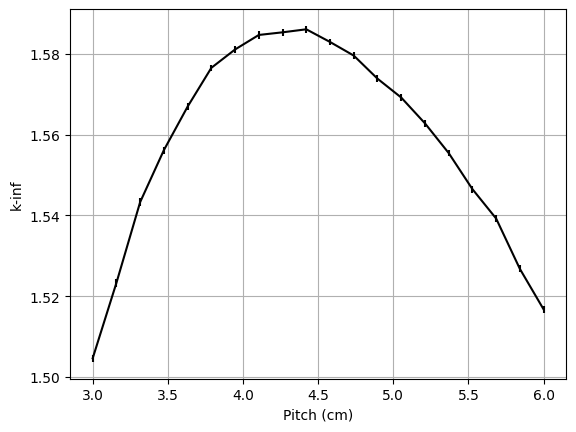

In [10]:
plt.errorbar(pp, [k.n for k in kk_beryllium], [k.std_dev for k in kk_beryllium], color='k')
plt.xlabel("Pitch (cm)")
plt.ylabel("k-inf")
plt.grid()

In [11]:
idx = np.argmax([k.n for k in kk_beryllium])
max_k = kk_beryllium[idx]
print("Optimized k: {:.3f}".format(max_k))

Optimized k: 1.586+/-0.001


In [12]:
# COMPUTE REACTIVITY CHANGE

rea_be = (1/k_ref - 1/max_k)*1e5
print("The optimized pin design yields a reactivity change of {:.0f} +/- {:.0f} pcm.".format(rea_be.nominal_value, rea_be.std_dev))

The optimized pin design yields a reactivity change of 13232 +/- 38 pcm.


.

.

## HEAVY WATER

The next try is Heavy Water:

In [4]:
def heavy_water(nps, pitch):
    fuel_enrichment = 3.0
    z_max = 1.0

    fuel_OR = 0.39218 # cm

    fuel_density = 10.31341 # g/cm3

    fuel_temperature = 900 #K
    mod_temperature = 600 #K


    ############### DEFINE MATERIALS

    fuel = openmc.Material(name='fuel')
    fuel.add_element('U', 1, enrichment=fuel_enrichment)
    fuel.add_element('O', 2)
    fuel.set_density('g/cc', fuel_density)
    fuel.temperature = fuel_temperature

    mod = openmc.Material(name='mod')
    mod.add_nuclide('H2', 2., 'ao')
    mod.add_nuclide('O16', 1., 'ao')
    mod.set_density('g/cc', 1)
    mod.temperature = mod_temperature
    mod.add_s_alpha_beta('c_D_in_D2O')

    materials = openmc.Materials([fuel, mod])
    materials.export_to_xml()



    ############### DEFINE GEOMETRY

    cyl_fo = openmc.ZCylinder(r=fuel_OR)
    box = openmc.model.rectangular_prism(pitch, pitch, boundary_type='reflective')
    z0 = openmc.ZPlane(z0=-z_max, boundary_type='reflective')
    z1 = openmc.ZPlane(z0=z_max, boundary_type='reflective')

    fuel_cell = openmc.Cell(name='fuel', fill=fuel)
    fuel_cell.region = -cyl_fo & +z0 & -z1
    mod_cell = openmc.Cell(name='moderator', fill=mod)
    mod_cell.region = +cyl_fo & box & +z0 & -z1

    pin_univ = openmc.Universe(cells=(fuel_cell, mod_cell))
    geometry = openmc.Geometry(pin_univ)
    geometry.export_to_xml()


    ############### DEFINE SETTINGS
    settings = openmc.Settings()
    settings.inactive = 50
    settings.batches = 200
    settings.particles = nps 
    settings.temperature={'method': 'interpolation','range':(300,1200)}

    lower_left = np.array([-pitch/2, -pitch/2, -z_max/2])
    upper_right = np.array([pitch/2, pitch/2, z_max/2])

    box = openmc.stats.Box(lower_left, upper_right, only_fissionable=True)
    src = openmc.Source(space=box)
    settings.source = src

    settings.export_to_xml()


    ############### RUN
    openmc.lib.init()
    openmc.lib.run()
    k = openmc.lib.keff()
    k = ufloat(k[0],k[1])
    openmc.lib.finalize()
    
    return k

In [8]:
pp_D2O = np.linspace(3, 13, 20)
kk_D2O= []


for p in pp_D2O:
    kk_D2O.append(heavy_water(nps=10000, pitch=p))

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      139/1    1.49147    1.49712 +/- 0.00163
      140/1    1.49623    1.49712 +/- 0.00161
      141/1    1.49086    1.49705 +/- 0.00160
      142/1    1.48423    1.49691 +/- 0.00159
      143/1    1.49007    1.49683 +/- 0.00157
      144/1    1.52102    1.49709 +/- 0.00157
      145/1    1.51136    1.49724 +/- 0.00156
      146/1    1.52447    1.49752 +/- 0.00157
      147/1    1.46532    1.49719 +/- 0.00159
      148/1    1.52659    1.49749 +/- 0.00160
      149/1    1.50335    1.49755 +/- 0.00159
      150/1    1.52050    1.49778 +/- 0.00159
      151/1    1.47638    1.49757 +/- 0.00159
      152/1    1.48958    1.49749 +/- 0.00157
      153/1    1.50275    1.49754 +/- 0.00156
      154/1    1.48370    1.49741 +/- 0.00155
      155/1    1.49473    1.49738 +/- 0.00154
      156/1    1.48800    1.49729 +/- 0.00152
      157/1    1.50470    1.49736 +/- 0.00151
      158/1    1.46398    1.49706 +/- 0.00153
      159/1    1.49740    1.49706 +/- 0.00152
      160/1    1.51122    1.49719 

       45/1    1.56830
       46/1    1.58658
       47/1    1.56189
       48/1    1.56188
       49/1    1.56360
       50/1    1.56329
       51/1    1.61715
       52/1    1.61569    1.61642 +/- 0.00073
       53/1    1.58598    1.60627 +/- 0.01015
       54/1    1.55676    1.59389 +/- 0.01431
       55/1    1.59128    1.59337 +/- 0.01110
       56/1    1.56414    1.58850 +/- 0.01029
       57/1    1.60917    1.59145 +/- 0.00918
       58/1    1.56767    1.58848 +/- 0.00849
       59/1    1.52812    1.58177 +/- 0.01005
       60/1    1.55582    1.57918 +/- 0.00936
       61/1    1.61411    1.58235 +/- 0.00904
       62/1    1.59761    1.58363 +/- 0.00835
       63/1    1.58929    1.58406 +/- 0.00769
       64/1    1.58461    1.58410 +/- 0.00712
       65/1    1.56903    1.58310 +/- 0.00671
       66/1    1.58176    1.58301 +/- 0.00627
       67/1    1.58384    1.58306 +/- 0.00589
       68/1    1.60396    1.58422 +/- 0.00568
       69/1    1.59477    1.58478 +/- 0.00540
       70/1

 Reading U235 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U235.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading H2 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_D_in_D2O from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_D_in_D2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========

      184/1    1.63809    1.62969 +/- 0.00155
      185/1    1.64679    1.62981 +/- 0.00155
      186/1    1.62098    1.62975 +/- 0.00154
      187/1    1.58961    1.62946 +/- 0.00155
      188/1    1.62418    1.62942 +/- 0.00154
      189/1    1.62764    1.62940 +/- 0.00153
      190/1    1.62018    1.62934 +/- 0.00152
      191/1    1.60862    1.62919 +/- 0.00152
      192/1    1.65044    1.62934 +/- 0.00151
      193/1    1.62313    1.62930 +/- 0.00150
      194/1    1.58723    1.62901 +/- 0.00152
      195/1    1.64281    1.62910 +/- 0.00151
      196/1    1.59410    1.62886 +/- 0.00152
      197/1    1.63301    1.62889 +/- 0.00151
      198/1    1.63039    1.62890 +/- 0.00150
      199/1    1.67189    1.62919 +/- 0.00152
      200/1    1.62417    1.62915 +/- 0.00151
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.1372e+00 seconds
   Reading cross sections          = 2.1

       95/1    1.65785    1.66538 +/- 0.00260
       96/1    1.67451    1.66558 +/- 0.00255
       97/1    1.65416    1.66534 +/- 0.00250
       98/1    1.64799    1.66498 +/- 0.00248
       99/1    1.66681    1.66501 +/- 0.00243
      100/1    1.63581    1.66443 +/- 0.00245
      101/1    1.65759    1.66430 +/- 0.00240
      102/1    1.65155    1.66405 +/- 0.00237
      103/1    1.65480    1.66388 +/- 0.00233
      104/1    1.66657    1.66393 +/- 0.00229
      105/1    1.64986    1.66367 +/- 0.00226
      106/1    1.65380    1.66349 +/- 0.00223
      107/1    1.64565    1.66318 +/- 0.00221
      108/1    1.65671    1.66307 +/- 0.00217
      109/1    1.68598    1.66346 +/- 0.00217
      110/1    1.65231    1.66327 +/- 0.00214
      111/1    1.66415    1.66329 +/- 0.00211
      112/1    1.68283    1.66360 +/- 0.00210
      113/1    1.66552    1.66363 +/- 0.00206
      114/1    1.69672    1.66415 +/- 0.00210
      115/1    1.63675    1.66373 +/- 0.00211
      116/1    1.67258    1.66386 

 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading H2 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_D_in_D2O from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_D_in_D2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.68962
        2/1    1.71129
   

      185/1    1.67349    1.69098 +/- 0.00161
      186/1    1.69360    1.69100 +/- 0.00159
      187/1    1.68913    1.69099 +/- 0.00158
      188/1    1.70162    1.69107 +/- 0.00157
      189/1    1.69093    1.69107 +/- 0.00156
      190/1    1.71565    1.69124 +/- 0.00156
      191/1    1.67892    1.69115 +/- 0.00155
      192/1    1.71908    1.69135 +/- 0.00155
      193/1    1.67986    1.69127 +/- 0.00154
      194/1    1.67839    1.69118 +/- 0.00154
      195/1    1.70567    1.69128 +/- 0.00153
      196/1    1.68202    1.69122 +/- 0.00152
      197/1    1.68782    1.69119 +/- 0.00151
      198/1    1.67712    1.69110 +/- 0.00150
      199/1    1.69141    1.69110 +/- 0.00149
      200/1    1.68683    1.69107 +/- 0.00148
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.4145e+00 seconds
   Reading cross sections          = 2.4053e+00 seconds
 Total time in simulation     

       96/1    1.72224    1.70754 +/- 0.00231
       97/1    1.71134    1.70762 +/- 0.00226
       98/1    1.73549    1.70820 +/- 0.00229
       99/1    1.71617    1.70836 +/- 0.00225
      100/1    1.67725    1.70774 +/- 0.00229
      101/1    1.69856    1.70756 +/- 0.00225
      102/1    1.70751    1.70756 +/- 0.00221
      103/1    1.72090    1.70781 +/- 0.00218
      104/1    1.70264    1.70771 +/- 0.00214
      105/1    1.70523    1.70767 +/- 0.00210
      106/1    1.71976    1.70788 +/- 0.00208
      107/1    1.74703    1.70857 +/- 0.00215
      108/1    1.71514    1.70868 +/- 0.00212
      109/1    1.70340    1.70859 +/- 0.00208
      110/1    1.71045    1.70863 +/- 0.00205
      111/1    1.73914    1.70913 +/- 0.00208
      112/1    1.71721    1.70926 +/- 0.00205
      113/1    1.67741    1.70875 +/- 0.00208
      114/1    1.71100    1.70879 +/- 0.00204
      115/1    1.69648    1.70860 +/- 0.00202
      116/1    1.71427    1.70868 +/- 0.00199
      117/1    1.71629    1.70880 

 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading H2 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_D_in_D2O from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_D_in_D2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.72952
        2/1    1.74874
   

      184/1    1.71607    1.72330 +/- 0.00145
      185/1    1.75442    1.72353 +/- 0.00146
      186/1    1.71033    1.72343 +/- 0.00145
      187/1    1.72236    1.72342 +/- 0.00144
      188/1    1.73422    1.72350 +/- 0.00143
      189/1    1.72562    1.72352 +/- 0.00142
      190/1    1.72259    1.72351 +/- 0.00141
      191/1    1.72356    1.72351 +/- 0.00140
      192/1    1.72785    1.72354 +/- 0.00139
      193/1    1.68782    1.72329 +/- 0.00140
      194/1    1.73862    1.72340 +/- 0.00140
      195/1    1.75682    1.72363 +/- 0.00141
      196/1    1.73705    1.72372 +/- 0.00140
      197/1    1.73788    1.72382 +/- 0.00139
      198/1    1.75303    1.72401 +/- 0.00140
      199/1    1.73082    1.72406 +/- 0.00139
      200/1    1.71609    1.72401 +/- 0.00138
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.5083e+00 seconds
   Reading cross sections          = 2.4

       95/1    1.73658    1.73790 +/- 0.00273
       96/1    1.73314    1.73779 +/- 0.00267
       97/1    1.73694    1.73777 +/- 0.00262
       98/1    1.71617    1.73732 +/- 0.00260
       99/1    1.76875    1.73797 +/- 0.00263
      100/1    1.72760    1.73776 +/- 0.00258
      101/1    1.75954    1.73819 +/- 0.00257
      102/1    1.70307    1.73751 +/- 0.00261
      103/1    1.74970    1.73774 +/- 0.00257
      104/1    1.73584    1.73771 +/- 0.00252
      105/1    1.71639    1.73732 +/- 0.00250
      106/1    1.74956    1.73754 +/- 0.00247
      107/1    1.73918    1.73757 +/- 0.00242
      108/1    1.75246    1.73782 +/- 0.00240
      109/1    1.73771    1.73782 +/- 0.00235
      110/1    1.73613    1.73779 +/- 0.00231
      111/1    1.71141    1.73736 +/- 0.00232
      112/1    1.74773    1.73753 +/- 0.00229
      113/1    1.74605    1.73766 +/- 0.00225
      114/1    1.73646    1.73764 +/- 0.00222
      115/1    1.75440    1.73790 +/- 0.00220
      116/1    1.72912    1.73777 

 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading H2 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_D_in_D2O from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_D_in_D2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.72135
        2/1    1.72843
   

      184/1    1.73930    1.74300 +/- 0.00156
      185/1    1.75154    1.74306 +/- 0.00155
      186/1    1.74569    1.74308 +/- 0.00154
      187/1    1.74649    1.74311 +/- 0.00152
      188/1    1.75599    1.74320 +/- 0.00152
      189/1    1.75206    1.74327 +/- 0.00151
      190/1    1.73279    1.74319 +/- 0.00150
      191/1    1.73130    1.74311 +/- 0.00149
      192/1    1.75439    1.74319 +/- 0.00148
      193/1    1.74393    1.74319 +/- 0.00147
      194/1    1.73308    1.74312 +/- 0.00146
      195/1    1.76470    1.74327 +/- 0.00146
      196/1    1.73053    1.74318 +/- 0.00145
      197/1    1.75677    1.74327 +/- 0.00145
      198/1    1.71598    1.74309 +/- 0.00145
      199/1    1.75443    1.74317 +/- 0.00144
      200/1    1.74006    1.74315 +/- 0.00143
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.3767e+00 seconds
   Reading cross sections          = 2.3

       94/1    1.75114    1.75362 +/- 0.00226
       95/1    1.73849    1.75328 +/- 0.00224
       96/1    1.77233    1.75369 +/- 0.00223
       97/1    1.74167    1.75344 +/- 0.00219
       98/1    1.76069    1.75359 +/- 0.00215
       99/1    1.75122    1.75354 +/- 0.00211
      100/1    1.76958    1.75386 +/- 0.00209
      101/1    1.77118    1.75420 +/- 0.00208
      102/1    1.77083    1.75452 +/- 0.00206
      103/1    1.75440    1.75452 +/- 0.00202
      104/1    1.75952    1.75461 +/- 0.00199
      105/1    1.73691    1.75429 +/- 0.00198
      106/1    1.75022    1.75422 +/- 0.00194
      107/1    1.71773    1.75358 +/- 0.00201
      108/1    1.70876    1.75280 +/- 0.00212
      109/1    1.76718    1.75305 +/- 0.00210
      110/1    1.74625    1.75293 +/- 0.00207
      111/1    1.72381    1.75246 +/- 0.00209
      112/1    1.74502    1.75234 +/- 0.00206
      113/1    1.74485    1.75222 +/- 0.00203
      114/1    1.74445    1.75210 +/- 0.00200
      115/1    1.75587    1.75215 

 Reading U235 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U235.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading H2 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_D_in_D2O from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_D_in_D2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========

      183/1    1.72086    1.75423 +/- 0.00157
      184/1    1.72782    1.75404 +/- 0.00157
      185/1    1.75696    1.75406 +/- 0.00155
      186/1    1.76950    1.75417 +/- 0.00155
      187/1    1.74952    1.75414 +/- 0.00154
      188/1    1.76300    1.75420 +/- 0.00153
      189/1    1.74447    1.75413 +/- 0.00152
      190/1    1.74816    1.75409 +/- 0.00151
      191/1    1.73287    1.75394 +/- 0.00150
      192/1    1.76902    1.75405 +/- 0.00150
      193/1    1.75961    1.75408 +/- 0.00149
      194/1    1.73545    1.75396 +/- 0.00148
      195/1    1.74396    1.75389 +/- 0.00147
      196/1    1.76709    1.75398 +/- 0.00147
      197/1    1.76521    1.75405 +/- 0.00146
      198/1    1.75846    1.75408 +/- 0.00145
      199/1    1.76786    1.75418 +/- 0.00144
      200/1    1.74937    1.75414 +/- 0.00143
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.4870e+00 se

       93/1    1.77779    1.75508 +/- 0.00311
       94/1    1.76738    1.75536 +/- 0.00306
       95/1    1.76500    1.75558 +/- 0.00299
       96/1    1.74541    1.75536 +/- 0.00294
       97/1    1.76464    1.75555 +/- 0.00288
       98/1    1.78326    1.75613 +/- 0.00288
       99/1    1.71145    1.75522 +/- 0.00296
      100/1    1.77641    1.75564 +/- 0.00293
      101/1    1.77958    1.75611 +/- 0.00291
      102/1    1.74781    1.75595 +/- 0.00286
      103/1    1.73801    1.75561 +/- 0.00283
      104/1    1.76642    1.75581 +/- 0.00278
      105/1    1.75250    1.75575 +/- 0.00273
      106/1    1.74147    1.75550 +/- 0.00269
      107/1    1.75079    1.75542 +/- 0.00265
      108/1    1.79253    1.75606 +/- 0.00268
      109/1    1.78391    1.75653 +/- 0.00268
      110/1    1.75460    1.75650 +/- 0.00263
      111/1    1.74329    1.75628 +/- 0.00260
      112/1    1.75461    1.75625 +/- 0.00255
      113/1    1.75337    1.75621 +/- 0.00251
      114/1    1.74688    1.75606 

 Reading U235 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U235.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading H2 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_D_in_D2O from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_D_in_D2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========

      183/1    1.72674    1.75688 +/- 0.00156
      184/1    1.77745    1.75703 +/- 0.00156
      185/1    1.75909    1.75704 +/- 0.00154
      186/1    1.77177    1.75715 +/- 0.00154
      187/1    1.74456    1.75706 +/- 0.00153
      188/1    1.73306    1.75689 +/- 0.00153
      189/1    1.73387    1.75672 +/- 0.00152
      190/1    1.76469    1.75678 +/- 0.00151
      191/1    1.73712    1.75664 +/- 0.00151
      192/1    1.75833    1.75665 +/- 0.00150
      193/1    1.75313    1.75663 +/- 0.00149
      194/1    1.77324    1.75674 +/- 0.00148
      195/1    1.71097    1.75643 +/- 0.00151
      196/1    1.78704    1.75664 +/- 0.00151
      197/1    1.74271    1.75654 +/- 0.00150
      198/1    1.77276    1.75665 +/- 0.00150
      199/1    1.75742    1.75666 +/- 0.00149
      200/1    1.74805    1.75660 +/- 0.00148
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.4275e+00 se

       93/1    1.75083    1.75947 +/- 0.00263
       94/1    1.79100    1.76019 +/- 0.00267
       95/1    1.76445    1.76028 +/- 0.00261
       96/1    1.76232    1.76033 +/- 0.00255
       97/1    1.72610    1.75960 +/- 0.00260
       98/1    1.72162    1.75881 +/- 0.00267
       99/1    1.75748    1.75878 +/- 0.00261
      100/1    1.77347    1.75908 +/- 0.00258
      101/1    1.74103    1.75872 +/- 0.00255
      102/1    1.73571    1.75828 +/- 0.00254
      103/1    1.73462    1.75783 +/- 0.00253
      104/1    1.76811    1.75802 +/- 0.00249
      105/1    1.76975    1.75824 +/- 0.00245
      106/1    1.73460    1.75781 +/- 0.00245
      107/1    1.79761    1.75851 +/- 0.00250
      108/1    1.74502    1.75828 +/- 0.00247
      109/1    1.75431    1.75821 +/- 0.00243
      110/1    1.77973    1.75857 +/- 0.00242
      111/1    1.76227    1.75863 +/- 0.00238
      112/1    1.76756    1.75878 +/- 0.00234
      113/1    1.75258    1.75868 +/- 0.00231
      114/1    1.75458    1.75861 

 Reading U235 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U235.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading H2 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_D_in_D2O from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_D_in_D2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========

      183/1    1.73746    1.75687 +/- 0.00164
      184/1    1.77769    1.75702 +/- 0.00164
      185/1    1.78519    1.75723 +/- 0.00164
      186/1    1.75783    1.75724 +/- 0.00163
      187/1    1.77603    1.75737 +/- 0.00162
      188/1    1.77421    1.75750 +/- 0.00161
      189/1    1.76241    1.75753 +/- 0.00160
      190/1    1.77902    1.75768 +/- 0.00160
      191/1    1.76534    1.75774 +/- 0.00159
      192/1    1.76879    1.75782 +/- 0.00158
      193/1    1.77485    1.75794 +/- 0.00157
      194/1    1.76047    1.75795 +/- 0.00156
      195/1    1.76781    1.75802 +/- 0.00155
      196/1    1.78444    1.75820 +/- 0.00155
      197/1    1.75729    1.75820 +/- 0.00154
      198/1    1.74335    1.75810 +/- 0.00153
      199/1    1.76236    1.75812 +/- 0.00152
      200/1    1.77324    1.75822 +/- 0.00152
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.3936e+00 se

       93/1    1.77674    1.76534 +/- 0.00270
       94/1    1.79192    1.76594 +/- 0.00270
       95/1    1.74916    1.76557 +/- 0.00267
       96/1    1.76143    1.76548 +/- 0.00261
       97/1    1.72957    1.76472 +/- 0.00267
       98/1    1.78380    1.76511 +/- 0.00264
       99/1    1.78772    1.76557 +/- 0.00263
      100/1    1.75834    1.76543 +/- 0.00258
      101/1    1.76632    1.76545 +/- 0.00253
      102/1    1.77479    1.76563 +/- 0.00249
      103/1    1.74098    1.76516 +/- 0.00248
      104/1    1.73015    1.76451 +/- 0.00252
      105/1    1.75703    1.76438 +/- 0.00248
      106/1    1.75297    1.76417 +/- 0.00244
      107/1    1.76142    1.76413 +/- 0.00240
      108/1    1.73701    1.76366 +/- 0.00240
      109/1    1.76484    1.76368 +/- 0.00236
      110/1    1.75568    1.76354 +/- 0.00233
      111/1    1.74994    1.76332 +/- 0.00230
      112/1    1.73483    1.76286 +/- 0.00231
      113/1    1.75794    1.76278 +/- 0.00227
      114/1    1.77779    1.76302 

 Reading U235 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U235.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading H2 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_D_in_D2O from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_D_in_D2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========

      183/1    1.72338    1.75727 +/- 0.00158
      184/1    1.76066    1.75730 +/- 0.00157
      185/1    1.75193    1.75726 +/- 0.00156
      186/1    1.76339    1.75730 +/- 0.00155
      187/1    1.74685    1.75723 +/- 0.00154
      188/1    1.74528    1.75714 +/- 0.00153
      189/1    1.71728    1.75685 +/- 0.00155
      190/1    1.75552    1.75684 +/- 0.00154
      191/1    1.77324    1.75696 +/- 0.00153
      192/1    1.78791    1.75718 +/- 0.00153
      193/1    1.73095    1.75699 +/- 0.00153
      194/1    1.76451    1.75705 +/- 0.00152
      195/1    1.76307    1.75709 +/- 0.00151
      196/1    1.76518    1.75714 +/- 0.00151
      197/1    1.72876    1.75695 +/- 0.00151
      198/1    1.73577    1.75681 +/- 0.00150
      199/1    1.76444    1.75686 +/- 0.00149
      200/1    1.73971    1.75674 +/- 0.00149
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.4035e+00 se

       93/1    1.77835    1.75755 +/- 0.00336
       94/1    1.76098    1.75763 +/- 0.00329
       95/1    1.75671    1.75761 +/- 0.00321
       96/1    1.74751    1.75739 +/- 0.00315
       97/1    1.76569    1.75757 +/- 0.00309
       98/1    1.72688    1.75693 +/- 0.00309
       99/1    1.76972    1.75719 +/- 0.00304
      100/1    1.74143    1.75687 +/- 0.00299
      101/1    1.78307    1.75739 +/- 0.00298
      102/1    1.75983    1.75743 +/- 0.00292
      103/1    1.73351    1.75698 +/- 0.00290
      104/1    1.75660    1.75697 +/- 0.00285
      105/1    1.73220    1.75652 +/- 0.00283
      106/1    1.76867    1.75674 +/- 0.00279
      107/1    1.74975    1.75662 +/- 0.00274
      108/1    1.73801    1.75630 +/- 0.00271
      109/1    1.72187    1.75571 +/- 0.00273
      110/1    1.74059    1.75546 +/- 0.00269
      111/1    1.74226    1.75525 +/- 0.00266
      112/1    1.73002    1.75484 +/- 0.00265
      113/1    1.74994    1.75476 +/- 0.00261
      114/1    1.79719    1.75542 

 Reading U235 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U235.h5
 Reading U236 from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/U236.h5
 Reading O17 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O17.h5
 Reading O16 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O16.h5
 Reading O18 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/O18.h5
 Reading H2 from /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/H2.h5
 Reading c_D_in_D2O from
 /home/lorenzomazzocco/Desktop/nuclear_data/endfb80_hdf5/c_D_in_D2O.h5
 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========

      183/1    1.72696    1.75331 +/- 0.00155
      184/1    1.74298    1.75323 +/- 0.00154
      185/1    1.73841    1.75312 +/- 0.00153
      186/1    1.78301    1.75334 +/- 0.00153
      187/1    1.75882    1.75338 +/- 0.00152
      188/1    1.75005    1.75336 +/- 0.00151
      189/1    1.77359    1.75350 +/- 0.00151
      190/1    1.76301    1.75357 +/- 0.00150
      191/1    1.75139    1.75356 +/- 0.00149
      192/1    1.75117    1.75354 +/- 0.00148
      193/1    1.73613    1.75342 +/- 0.00147
      194/1    1.73085    1.75326 +/- 0.00147
      195/1    1.76296    1.75333 +/- 0.00146
      196/1    1.78680    1.75356 +/- 0.00147
      197/1    1.72784    1.75338 +/- 0.00147
      198/1    1.76788    1.75348 +/- 0.00146
      199/1    1.74143    1.75340 +/- 0.00146
      200/1    1.75000    1.75338 +/- 0.00145
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 2.3840e+00 se

       93/1    1.74788    1.74767 +/- 0.00300
       94/1    1.75469    1.74783 +/- 0.00293
       95/1    1.76577    1.74823 +/- 0.00289
       96/1    1.73881    1.74802 +/- 0.00284
       97/1    1.71965    1.74742 +/- 0.00284
       98/1    1.75592    1.74760 +/- 0.00279
       99/1    1.74935    1.74763 +/- 0.00273
      100/1    1.72798    1.74724 +/- 0.00270
      101/1    1.74423    1.74718 +/- 0.00265
      102/1    1.72366    1.74673 +/- 0.00264
      103/1    1.70625    1.74597 +/- 0.00270
      104/1    1.74228    1.74590 +/- 0.00265
      105/1    1.72801    1.74557 +/- 0.00262
      106/1    1.75047    1.74566 +/- 0.00257
      107/1    1.74123    1.74558 +/- 0.00253
      108/1    1.72433    1.74522 +/- 0.00251
      109/1    1.74458    1.74520 +/- 0.00247
      110/1    1.75514    1.74537 +/- 0.00243
      111/1    1.73647    1.74522 +/- 0.00240
      112/1    1.75381    1.74536 +/- 0.00236
      113/1    1.77282    1.74580 +/- 0.00237
      114/1    1.73821    1.74568 

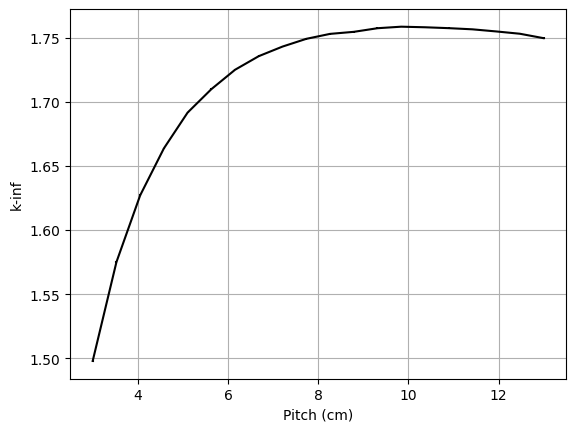

In [10]:
plt.errorbar(pp_D2O, [k.n for k in kk_D2O], [k.std_dev for k in kk_D2O], color='k')
plt.xlabel("Pitch (cm)")
plt.ylabel("k-inf")
plt.grid()

In [13]:
idx = np.argmax([k.n for k in kk_D2O])
print("Optimized k: {:.3f}".format(kk_D2O[idx]))
print("Optimized pitch: {:.2f} cm".format(pp_D2O[idx]))

Optimized k: 1.758+/-0.001
Optimized pitch: 9.84 cm


It's clear that Heavy Water outperforms Beryllium by a great margin. 

In [24]:
# COMPUTE REACTIVITY CHANGE

rea_hw = (1/k_ref - 1/kk_D2O[idx])*1e5
print("The optimized heavy water channel design yields a reactivity increase of {:.0f} +/- {:.0f} pcm, of which {:.0f} +/- {:.0f} pcm comes just from removing the cladding.".format(rea_hw.nominal_value, rea_hw.std_dev, rea_noclad.nominal_value, rea_noclad.std_dev))

The optimized heavy water channel design yields a reactivity increase of 19413 +/- 27 pcm, of which 2439 +/- 27 pcm comes just from removing the cladding.
